# **Kinetic Monte Carlo: Esercizio 2 punto 2**

We model growth on the (001) Ag surface using a ℎ(𝑥,𝑦) solid-on-solid representation on a square lattice. A 𝐿 × 𝐿 = 60 × 60 periodic cell is considered, unless differently indicated. Atomic interactions are limited to first-neighbors only, with bonding energy 𝐽1 = − 0.345 𝑒𝑉. Each Ag atom is bonded to 4 neighbors from the underlying layer, i.e. 𝐽0 = 4𝐽1, and can form up to 4 lateral bonds (each of energy 𝐽1) with atoms in adjacent columns.


## *SVOLGIMENTO PUNTO 2*

Perform growth simulations at 𝑇 = 650 𝐾 with deposition flux 𝜙 = [10, 1, 0.1, 0.01, 0.0001] 𝑀𝐿/𝑠, up to a nominal thickness of 𝜃 = 5 𝑀𝐿.

---

### 0) Importazioni e dati

In [1]:
import numpy as np
from CMS.MonteCarlo.KineticMonteCarlo import KineticMonteCarlo
from CMS.MonteCarlo.ioKMC import XYZwriter

### #) Simulazione

#### Dati

In [2]:
flux = [10., 1., 0.1, 0.01, 0.0001] # ML/s monolayers per secondo
temperature = 650 # K -> DIFFUSIONE
nominal_coverage = 5.0  # ML monolayers 
L = (60,60) # dimensioni della griglia in unità di celle cristalline

**Ricostruendo tutti i primi vicini ogni volta:**\
<20s per i primi 3 flussi insieme, 15s per 0.01, 6min per 0.0001

**Modificando solo i primi vicini coinvolti nel singolo evento (ma ricalcolando i rate completamente ogni volta):**\
10s per i primi 3 flussi insieme, 10s per 0.01, 4min30s per 0.0001

**Modificando solo i primi vicini coinvolti nel singolo evento (aggiornando solo i rate necessari):**\
4s per i primi 3 flussi insieme, 6s per 0.01, 1min30s per 0.0001

**Usando rate pre-calcolati invece che rifare l'esponenziale ogni volta:**\
4s per i primi 3 flussi insieme, 6s per 0.01,  1min30s per 0.0001

**Usando la somma delle righe per velocizzare find_move:**\
4s per i primi 3 flussi insieme, 5s per 0.01,  1min10s per 0.0001

In [3]:
result_dict = {}

for f in flux:
    print(f"--- Inizio simulazione per flusso = {f} ML/s ---")
    # calcolo il tempo di simulazione necessario per raggiungere la copertura nominale
    simulation_time = nominal_coverage / f  # s secondi
    # voglio salvare solo il 10% delle deposizioni in UN SOLO layer
    max_write_steps = int(L[0] * L[1] * 0.1)
    # se si vuole salvare il 30% di un layer successivo, supponiamo l'ultimo layer:
    start_time = 4*simulation_time / 5  # inizia a salvare dopo l'80% del tempo totale
    # preparo un oggetto xyz_writer che si occupa di salvare le posizioni
    xyz_writer = XYZwriter(output_folder=f"output/2_2/10%layer_f={f}_ML_per_s/", 
                           max_deposition_steps=max_write_steps,
                           start_time=start_time)
    # eseguo la simulazione
    simulation = KineticMonteCarlo(L=L, flux=f, T=temperature, seed=42, xyz_writer=xyz_writer)
    # non puoi passargli il tempo come keyword argument end_time=sim_time sennò jitclass si lamenta 
    result = simulation.run(simulation_time)
    # salvo il risultato
    result_dict[f] = result

--- Inizio simulazione per flusso = 10.0 ML/s ---
--- Inizio simulazione per flusso = 1.0 ML/s ---
--- Inizio simulazione per flusso = 0.1 ML/s ---
--- Inizio simulazione per flusso = 0.01 ML/s ---
--- Inizio simulazione per flusso = 0.0001 ML/s ---


---

## Analisi risultati

Observe the different growth modes and compare the behavior of 𝜎(𝜃) . In the cases corresponding to layer-by-layer growth, what is the effect of decreasing 𝜙 (look at the early stages, e.g. after deposition of 0.1 𝑀𝐿)? Interpret the results. If the growth apparatus only works at 𝜙 = 1 𝑀𝐿/𝑠, is it possible to achieve the same behavior previously observed for 𝜙 = 0.01 𝑀𝐿/𝑠 by tuning the temperature?


### plot roughness

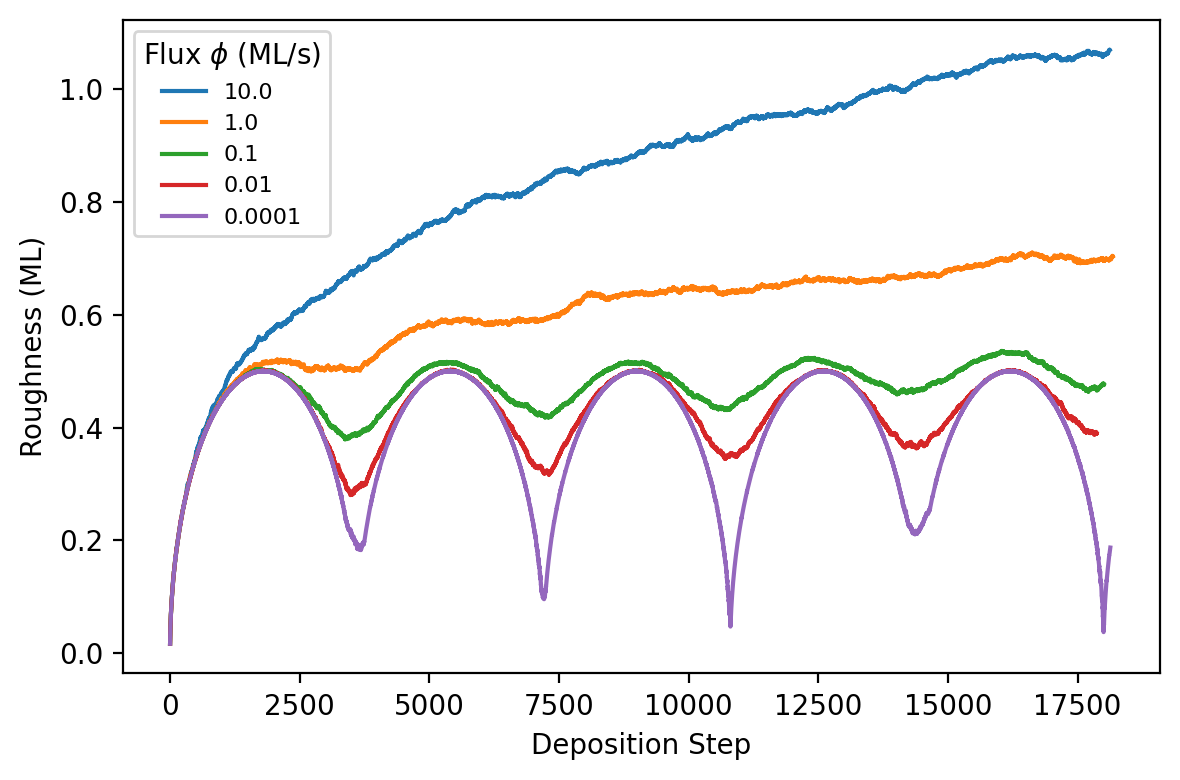

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4), dpi=200)
for f in flux:
    # proviamo vs step invece che vs time
    plt.plot(range(len(result_dict[f].rms_roughness_list)), result_dict[f].rms_roughness_list, label=f"{f}")
plt.xlabel("Deposition Step")
plt.ylabel("Roughness (ML)")
#plt.title(f"Roughness vs step at T = {temperature} K")
plt.legend(title=r"Flux $\phi$ (ML/s)", fontsize=8)
plt.tight_layout()
plt.show()

## Ora:
- video ovito
- guardare il primo 10% del layer per vedere come cambia la nucleazione

In [5]:
# rifaccio 1 ML/s ma a 800 k per vedere se riesco a ricostruire il comportamento di 0.01 a 650
simulation_time = nominal_coverage / 1  # s secondi
# eseguo la simulazione
simulation = KineticMonteCarlo(L=L, flux=1, T=800, seed=42)
# non puoi passargli il tempo come keyword argument end_time=sim_time sennò jitclass si lamenta 
result = simulation.run(simulation_time)

### Ricreare il comportamento di 0.01 ML/s a 650 K con 1 ML/s tunando T

**COME PREVEDO LA TEMPERATURA?**

Per mantenere la stessa curva di rugosità, mantengo costante il rapporto tra la velocità di diffusione e la velocità di deposizione:
$$
\frac{k_\text{diff}(T_1)}{\phi_1} \approx \frac{k_\text{diff}(T_2)}{\phi_2}
$$
Il tasso di diffusione su superficie piatta segue la legge di Arrhenius:
$$
k_\text{diff}(T) \approx \nu e^{-\frac{E_b}{k_B T}}
$$
dove $E_b=−J_0=1.38 eV$ per un atomo solitario. Imponendo l'uguaglianza dei rapporti, otteniamo la formula per la nuova temperatura $T_2$:
$$
\frac{1}{T_2} = \frac{1}{T_1} - \frac{k_B}{E_b} \ln{\frac{\phi_2}{\phi_1}}
$$
si ha:
- $\frac{\phi_2}{\phi_1}$ = 100
- $T_1 = 650 K$

per cui: $T_2 \approx 800 K$ 
​

$$\frac{k_\text{diff}(T_1)}{\phi_1} \simeq \frac{k_\text{diff}(T_2)}{\phi_2} \iff \frac{1}{T_2} \simeq \frac{1}{T_1} - \frac{k_B}{E_b} \ln{\frac{\phi_2}{\phi_1}}

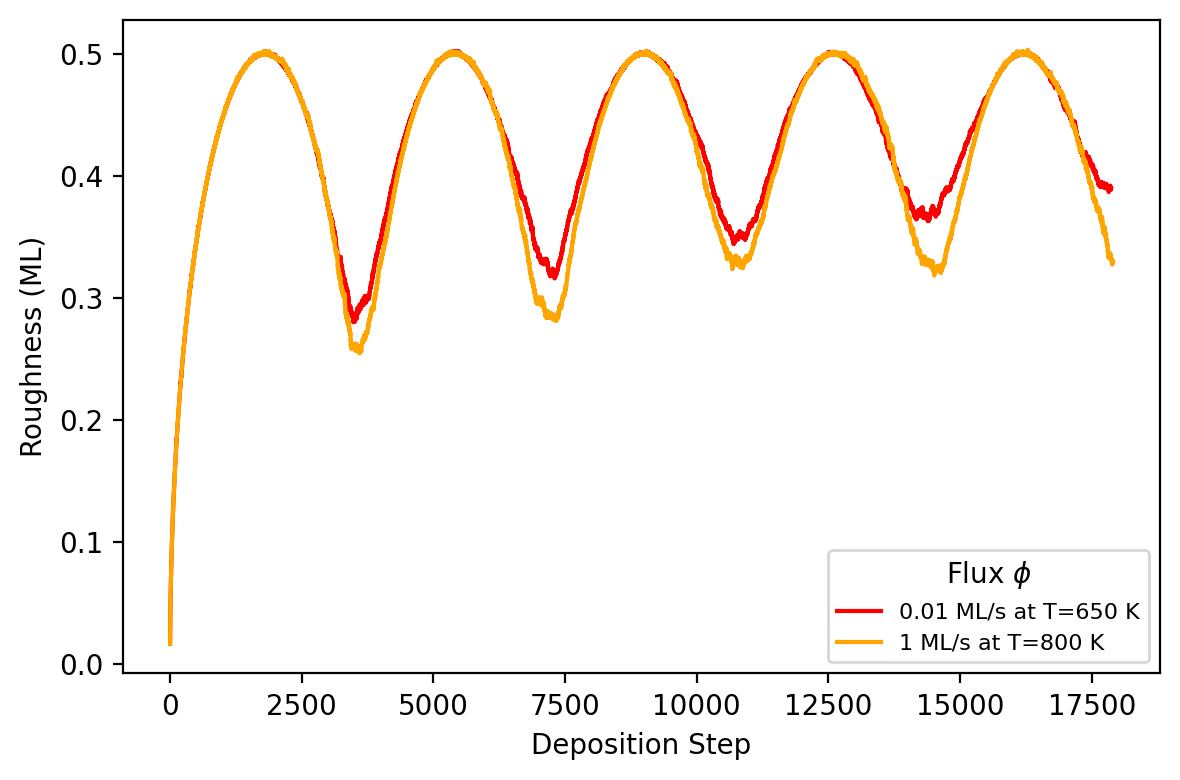

In [7]:
plt.figure(figsize=(6,4), dpi=200)
plt.plot(range(len(result_dict[0.01].rms_roughness_list)), result_dict[0.01].rms_roughness_list, label=f"0.01 ML/s at T=650 K", color='red')
plt.plot(range(len(result.rms_roughness_list)), result.rms_roughness_list, label=f"1 ML/s at T=800 K", color='orange')
plt.xlabel("Deposition Step")
plt.ylabel("Roughness (ML)")
#plt.title(f"Roughness vs step at T = 650 and 800 K, F = 0.01 and 1 ML/s")
plt.legend(title=r"Flux $\phi$", fontsize=8)
plt.tight_layout()
plt.show()